In [1]:
#import all we need --> set ipympl for inline graphic interaction
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import exspy
import scipy
import os
import mplcyberpunk
import matplotlib 
import h5py
import py4DSTEM
from py4Dutils.Added_Functions_For_EELS_Mapping import Set_Wrong_Pixels_to_NaN, Set_Wrong_Pixels_to_Zero, Set_Wrong_Pixels_to_MeanValue
plt.style.use('cyberpunk')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
#need to be set for the interactive GUI
%matplotlib ipympl

In [3]:
!pip freeze  > requirements.txt  # Python3

In [2]:
#load the calibrated data

fp = "/masc_shared/ag_volz/Oliver_Maßmeyer/Perovskites/2024_07_19_2024_perovskite_NBD"
fn = 'NBD_08mrad_2c_4cm_001_for_py4dstem_cali.h5'


## load the py4dstem datacube again

dataset = py4DSTEM.read(os.path.join(fp,fn))
# NBD_Data = hs.load(filenames = os.path.join(fp,fn),signal_type=None) 

Reading PointListArray: 100%|██████████| 16384/16384 [00:01<00:00, 9652.12PointList/s]


In [3]:
## check calibration state
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.01823836
             R_pixel_size:          0.014573
             Q_pixel_units:         A^-1
             R_pixel_units:         μm
             QR_flip:               False
             QR_rotation:           0
             QR_rotation_degrees:   0.0
             _root_treepath:        
             a:                     39.71679242913384
             b:                     37.394710369945216
             qx0:                   2D-array
             qx0_mean:              124.62574621094245
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_mean:              128.5142598508146
             qy0_shift:             2D-array
             theta:                 -0.601805147830796
)

In [4]:
dataset_shifted = dataset.copy()

In [5]:
## apply shift to datacube

py4DSTEM.preprocess.preprocess.datacube_diffraction_shift(
    dataset_shifted,
    -dataset_shifted.calibration.get_qx0shift(), #pre sign stuff like always =)
    -dataset_shifted.calibration.get_qy0shift(), #pre sign stuff like always =)
    periodic=True,
    bilinear=True, ## bilinear very fast compared to FFT --> FFT produced here artifacts 
)

Shifting images: 100%|██████████| 16384/16384 [00:04<00:00, 4072.80 images/s]


DataCube( A 4-dimensional array of shape (128, 128, 256, 256) called 'NBD_Dataset001',
          with dimensions:

              Rx = [0.0,0.014573,0.029146,...] μm
              Ry = [0.0,0.014573,0.029146,...] μm
              Qx = [0.0,0.01823836,0.03647672,...] A^-1
              Qy = [0.0,0.01823836,0.03647672,...] A^-1
)

In [6]:
dataset_shifted_elliptic = dataset_shifted.copy()
dataset_shifted_elliptic

DataCube( A 4-dimensional array of shape (128, 128, 256, 256) called 'NBD_Dataset001',
          with dimensions:

              Rx = [0.0,0.014573,0.029146,...] μm
              Ry = [0.0,0.014573,0.029146,...] μm
              Qx = [0.0,0.01823836,0.03647672,...] A^-1
              Qy = [0.0,0.01823836,0.03647672,...] A^-1
)

In [7]:
## params taken from ellipse fit of Bragg vector map

p_ellipse = (125.11677268865398,
 128.5968572899113,
 39.71679242913384,
 37.394710369945216,
 -0.601805147830796)

p_ellipse

(125.11677268865398,
 128.5968572899113,
 39.71679242913384,
 37.394710369945216,
 -0.601805147830796)

In [8]:
## appy elliptical correction

py4DSTEM.process.utils.elliptical_resample_datacube(
    dataset_shifted_elliptic,
    p_ellipse,
    mask=None,
    maskThresh=0.99,
)

100%|██████████| 16384/16384 [02:28<00:00, 110.29it/s]


DataCube( A 4-dimensional array of shape (128, 128, 256, 256) called 'NBD_Dataset001',
          with dimensions:

              Rx = [0.0,0.014573,0.029146,...] μm
              Ry = [0.0,0.014573,0.029146,...] μm
              Qx = [0.0,0.01823836,0.03647672,...] A^-1
              Qy = [0.0,0.01823836,0.03647672,...] A^-1
)

In [9]:
## save datacube with elliptic and shift correction applied

# save the calibrated dataset
dataset_save_path = os.path.join(fp,"NBD_08mrad_2c_4cm_001_for_py4dstem_cali_elipse.h5")
py4DSTEM.save(
    dataset_save_path,
    dataset_shifted_elliptic,
    mode='o'    # write' mode
)

In [10]:
## quick visualization using hyperspy gui
Dataset_hyperspy_visualization = hs.signals.Signal2D(dataset_shifted_elliptic.data)

Dataset_hyperspy_visualization.plot()

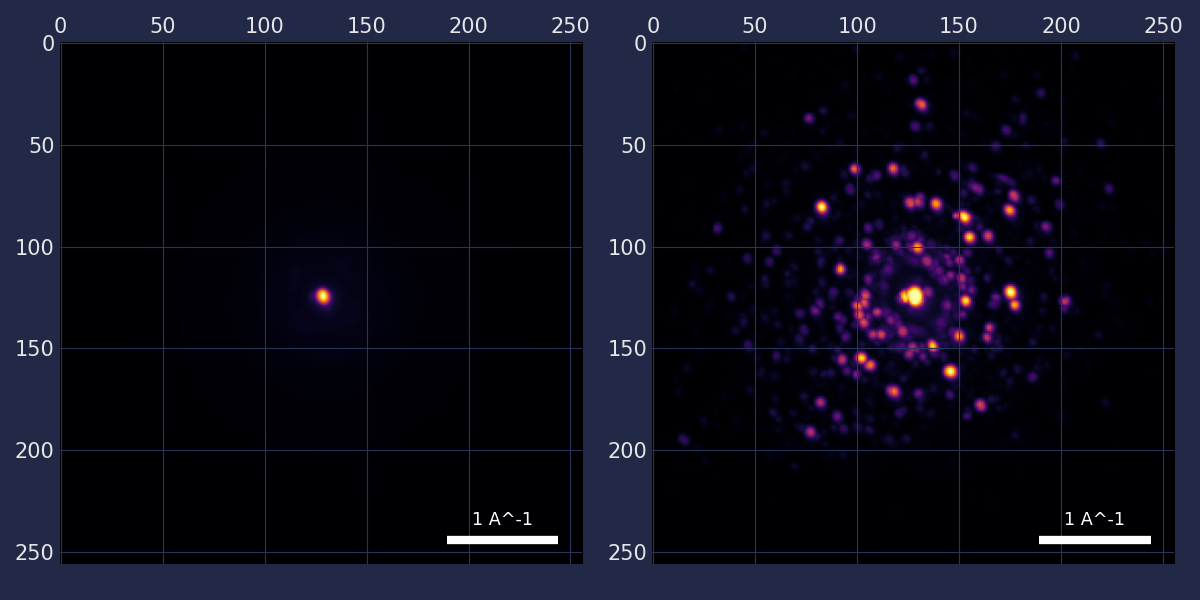

In [11]:
## make corrected dp_max_image
# Calculate these images:
#     -max diffraction pattern from dataset
#     -mean diffraction pattern from dataset
#     -mean diffraction pattern from probe
dataset_shifted_elliptic.get_dp_max();
dataset_shifted_elliptic.get_dp_mean();

py4DSTEM.show(
    [
        dataset_shifted_elliptic.tree('dp_mean'), 
        dataset_shifted_elliptic.tree('dp_max'), 
        # dataset_probe.tree('dp_mean'),
    ],
    vmax=1,
    power=0.5,
    cmap='inferno',
    scaling='log',
)


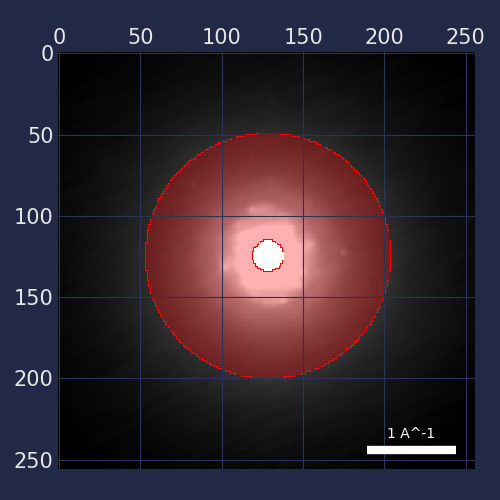

100%|██████████| 16384/16384 [00:00<00:00, 28045.88it/s]


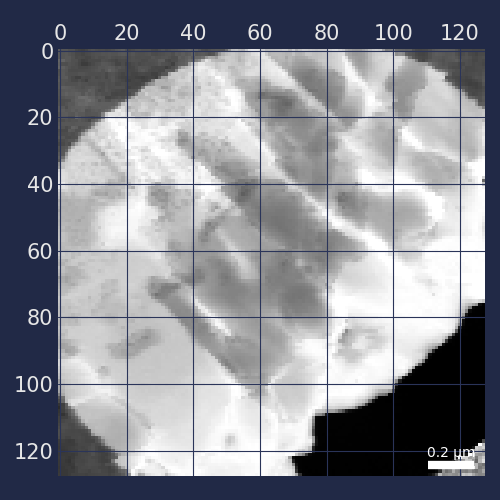

In [12]:
## make virtual images

# Create an annular dark field (ADF) virtual detector using user-chosen values:
center = (dataset_shifted_elliptic.calibration.qx0_mean,dataset_shifted_elliptic.calibration.qy0_mean)
radii = (10,75)

# Plot the ADF detector
dataset_shifted_elliptic.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii
    )
)

# Calculate the ADF image
dataset_shifted_elliptic.get_virtual_image(
    mode = 'annulus',
    geometry = ((center),radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.show(
    dataset_shifted_elliptic.tree('dark_field'),
)


WARNING | Hyperspy | `signal_type='diffraction'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


WARNING | Hyperspy | `signal_type='diffraction'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


[########################################] | 100% Completed | 101.27 ms


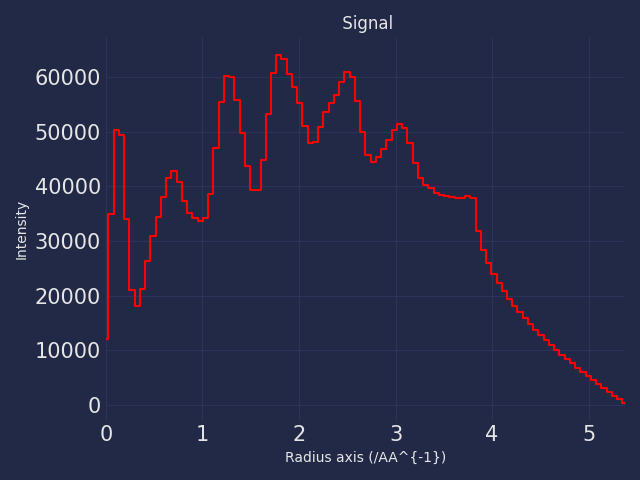

In [50]:
import pyxem as pxm
import hyperspy.api as hs
import numpy as np

s = pxm.data.tilt_boundary_data()
s.calibration(
    center=None
)  # set the center to None to use center of the diffraction patterns
s.calibration.units = "/AA^{-1}"
s.calibration.scale = 0.03  # To angstroms
s1d = s.get_azimuthal_integral1d(npt=100, inplace=False)

s1d.sum().plot()

In [ ]:
Dataset_hyperspy_visualization

In [38]:
## make polar transformation

polardata = py4DSTEM.PolarDatacube(
    dataset_shifted_elliptic,
    qmin = 3.0,
    qmax = 90.0,
    qstep = 1,
    n_annular = 360,
    two_fold_symmetry = True,
    qscale = 1.0,
)

In [31]:
## check polar datacube with hyperspy

## quick visualization using hyperspy gui
polardata_hyperspy_visualization = hs.signals.Signal2D(polardata.data)

polardata_hyperspy_visualization.plot()


ValueError: The signal dimension cannot be greater than the number of axes which is 1

some peaks have a prominence of 0
some peaks have a prominence of 0


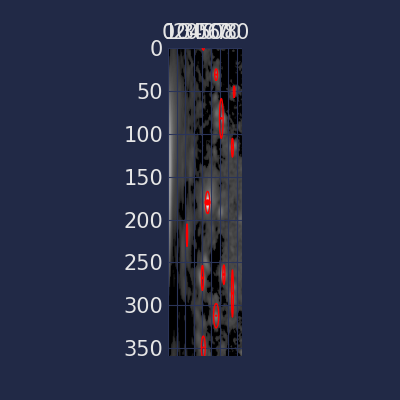

In [39]:
# Testing peak detection hyperparameters

x,y = 125,125
# x,y = 40,40

#parameters
detect_params = {
    'sigma_annular_deg': 5.0,
    'sigma_radial_px': 5.0,
    'threshold_abs': 0.5,
    'threshold_prom_radial': 1.0,
    'threshold_prom_annular': 1.0,
    'scale_sigma_annular': 0.3,
    'scale_sigma_radial': 0.1,
}


#test single pattern fit
peaks_polar, sig_bg, sig_bg_mask = polardata.find_peaks_single_pattern(
    x,
    y,
    **detect_params,
    return_background=True,
    plot_result=True,
    plot_power_scale=0.2,
    plot_scale_size=0.01,
    figsize=(4, 4),
    returnfig=False,
)


In [40]:
## test fitting all data
# initial peak detection for all probe positions
polardata.find_peaks(
    **detect_params,
)

Finding peaks : 100%|██████████| 16384/16384 [04:34<00:00, 59.64 images/s]


AttributeError: 'PolarDatacube' object has no attribute 'pdf_r'

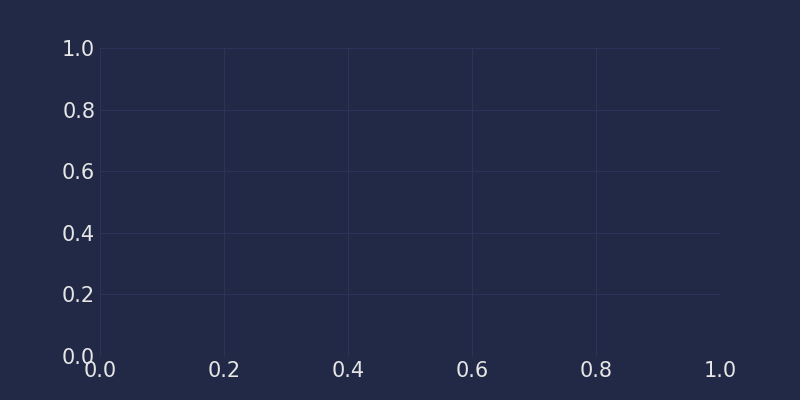

In [42]:
polardata.plot_pdf()

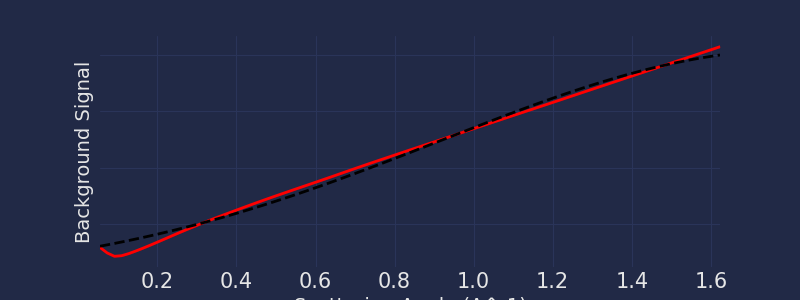

In [16]:
polardata.model_radial_background(
    ring_position = 20,
    ring_sigma = 3.0,
    ring_int = None,
    refine_model = True,
    figsize = (8,3),
)

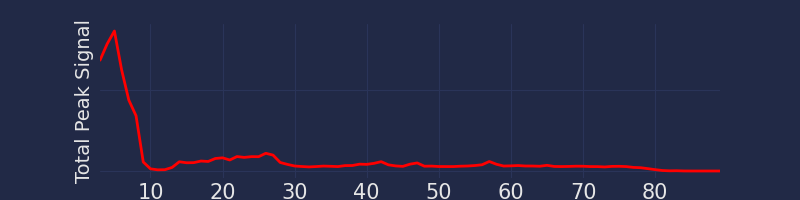

In [22]:
# This is a 1D histogram of the detected peaks, before refinement
polardata.plot_radial_peaks(
    q_pixel_units = True,
    figsize = (8,2),
)

In [23]:
orient_hist = polardata.make_orientation_histogram(
    [
        [3, 10],  
        [20, 30], 
    ],
    normalize_intensity_image = True,
    normalize_intensity_stack = False,
    use_refined_peaks = False,
)

Orientation histogram is using non-refined peak positions
Generating histogram 1: 100%|██████████| 16384/16384 [00:00<00:00, 47359.40 probe positions/s]


Interpolating orientation matrices ... done.


In [29]:
# Plot the total signals in each orientation matrix
py4DSTEM.show(
    [
        orient_hist[0].  nansum(axis=2),
        orient_hist[1].sum(axis=2),
    ],
    # cmap='gray',
    axsize=(3,3),
    # ticks = True,
)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'nansum'

In [30]:
orient_hist[0]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [ ]:
## care takes for ever !!
#polardata.refine_peaks()

Refining peaks :   0%|          | 56/16384 [04:30<5:38:58,  1.25s/ probe positions]  

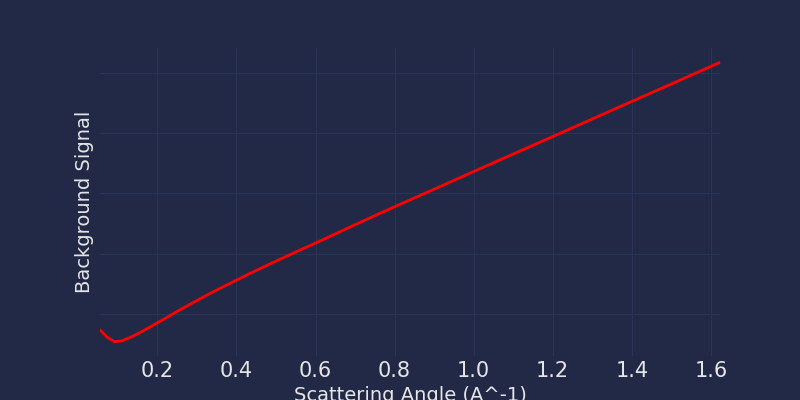

In [168]:
polardata.plot_radial_background()

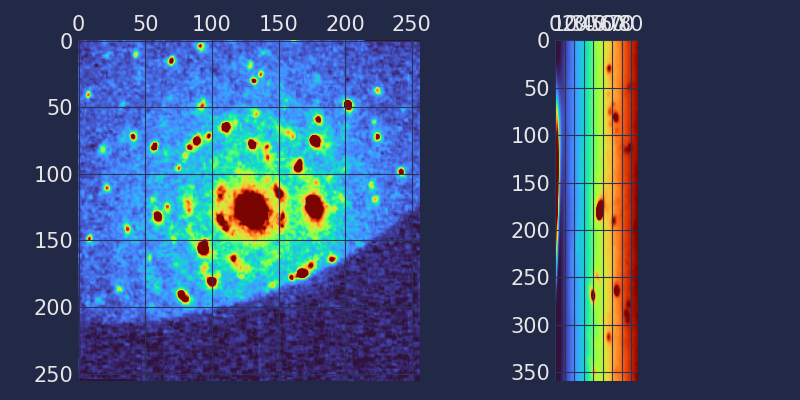

In [57]:
# show polar transformation for different probe positions

# x,y = 40,20
x,y = 125,125
# x,y = 1,160

# Show pattern in cartesian + polar
py4DSTEM.show( 
    [
        dataset_shifted_elliptic.data[x,y],
        polardata.data[x,y],
    ],
    # intensity_range = 'absolute',
    # vmax = 40,
    cmap = 'turbo',
    axsize = (4,4),
)

AttributeError: 'PolarDatacube' object has no attribute 'pdf_r'

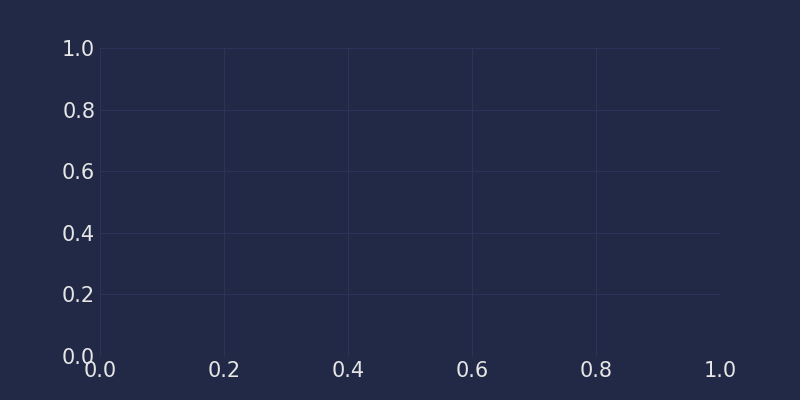

In [15]:
polardata.plot_pdf()

In [13]:
## use rdf

py4DSTEM.process.polar.

Type:        module
String form: <module 'py4DSTEM.process' from '/home/massmeye/.conda/envs/4dstem/lib/python3.11/site-packages/py4DSTEM/process/__init__.py'>
File:        ~/.conda/envs/4dstem/lib/python3.11/site-packages/py4DSTEM/process/__init__.py
Source:     
from py4DSTEM import is_package_lite
from py4DSTEM.process.polar import PolarDatacube
from py4DSTEM.process.strain.strain import StrainMap

from py4DSTEM.process import phase
from py4DSTEM.process import calibration
from py4DSTEM.process import utils

try:
    from py4DSTEM.process import classification
except (ImportError, ModuleNotFoundError) as exc:
    if not is_package_lite:
        raise exc

from py4DSTEM.process import diffraction

try:
    from py4DSTEM.process import wholepatternfit
except (ImportError, ModuleNotFoundError) as exc:
    if not is_package_lite:
        raise exc

In [74]:
dp1 = dataset_shifted_elliptic.get_local_ave_dp(
    124,
    124,
    radial_bksb=False,
    sigma=2,
    braggmask=False,
    braggvectors=None,
    braggmask_radius=None,
)

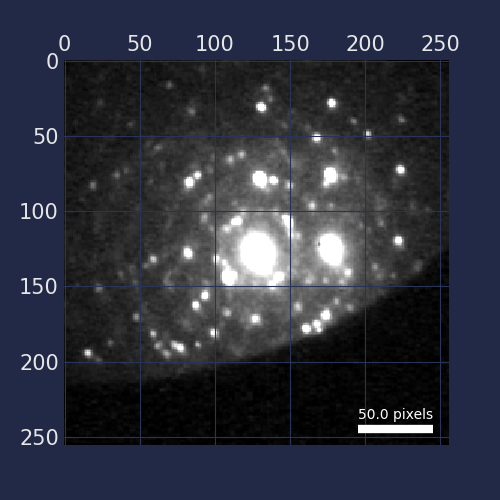

In [75]:
py4DSTEM.show(
    dp1,
    scalebar = True,
    scaling='log',
)

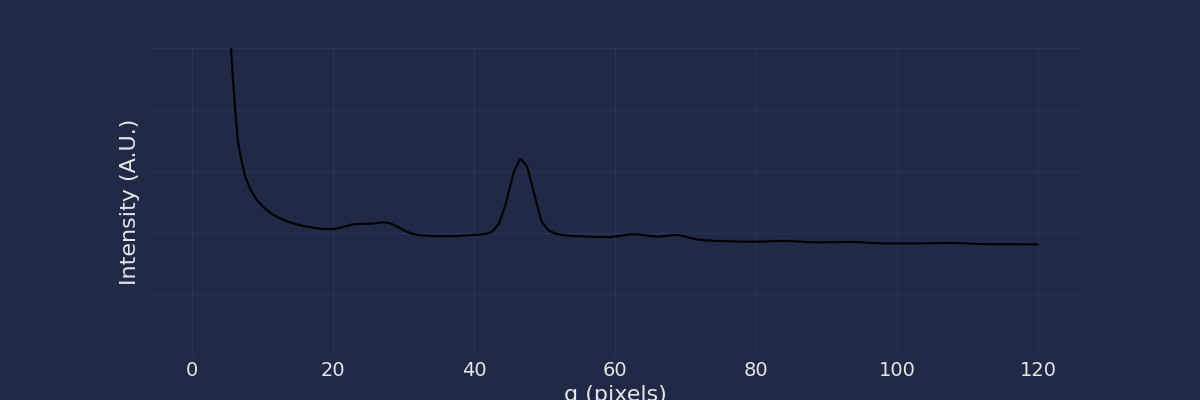

In [76]:
q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    dp1,
    x0=dataset_shifted_elliptic.calibration.qx0_mean,
    y0=dataset_shifted_elliptic.calibration.qy0_mean,
    rmax=120,
)

py4DSTEM.visualize.show_qprofile(
    q = q,
    intensity = intensity_radial,
    ymax = 500000,
    # scale='log',
)


In [38]:
py4DSTEM.process.utils.radial_integral

(array([5.0000e-02, 1.5000e-01, 2.5000e-01, ..., 1.8275e+02, 1.8285e+02,
        1.8295e+02]),
 masked_array(data=[6765211.270174309, 6765211.270174308,
                    6765211.270174301, ..., --, --, --],
              mask=[False, False, False, ...,  True,  True,  True],
        fill_value=1e+20))

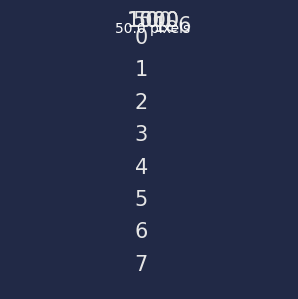

In [42]:
plt.plot(ri1[0])
plt.show()

In [13]:
## aim get radial integral for each pixel

py4DSTEM.process.utils.radial_integral(
    dataset_shifted_elliptic.data,
    x0=dataset_shifted_elliptic.calibration.qx0_mean,
    y0=dataset_shifted_elliptic.calibration.qy0_mean,
)

ValueError: too many values to unpack (expected 2)

In [ ]:
q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    bragg_vector_map_corrected,
    x0=center[0],
    y0=center[1],
)

## Explore py4dstem util functions


In [101]:
dataset_shifted_elliptic.get_local_ave_dp

dataset_shifted_elliptic.get_radial_bkgrnd
dataset_shifted_elliptic.get_radial_bksb_dp

dataset_shifted_elliptic.get_virtual_diffraction

dataset_shifted_elliptic.get_virtual_image


Signature:
py4DSTEM.preprocess.radialbkgrd.savgol_filter(
    x,
    window_length,
    polyorder,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp',
    cval=0.0,
)
Source:   
def savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0,
                  axis=-1, mode='interp', cval=0.0):
    """ Apply a Savitzky-Golay filter to an array.

    This is a 1-D filter. If `x`  has dimension greater than 1, `axis`
    determines the axis along which the filter is applied.

    Parameters
    ----------
    x : array_like
        The data to be filtered. If `x` is not a single or double precision
        floating point array, it will be converted to type ``numpy.float64``
        before filtering.
    window_length : int
        The length of the filter window (i.e., the number of coefficients).
        If `mode` is 'interp', `window_length` must be less than or equal
        to the size of `x`.
    polyorder : int
        The order of the polynomial used to fit the samples.


In [20]:
py4DSTEM.process.utils.radial_elliptical_integral??

Signature:
py4DSTEM.process.utils.radial_elliptical_integral(
    ar,
    dr,
    p_ellipse,
    rmax=None,
)
Source:   
def radial_elliptical_integral(
    ar,
    dr,
    p_ellipse,
    rmax=None,
):
    """
    Computes the radial integral of array ar from center (x0,y0) with a step size in r of
    dr.

    Args:
        ar (2d array): the data
        dr (number): the r sampling
        p_ellipse (5-tuple): the parameters (x0,y0,a,b,theta) for the ellipse
        r_max (float):  maximum radial value

    Returns:
        (2-tuple): A 2-tuple containing:

            * **rbin_centers**: *(1d array)* the bins centers of the radial integral
            * **radial_integral**: *(1d array)* the radial integral
        radial_integral (1d array) the radial integral
    """
    x0, y0 = p_ellipse[0], p_ellipse[1]
    if rmax is None:
        rmax = int(
            max(
                (
                    np.hypot(x0, y0),
                    np.hypot(x0, ar.shape[1] - y0),
            

In [24]:
## i think this should be used for elliptical correction of the whole datacube --> find also shift correction
py4DSTEM.process.utils.elliptical_resample_datacube??

Signature:
py4DSTEM.process.utils.elliptical_resample_datacube(
    datacube,
    p_ellipse,
    mask=None,
    maskThresh=0.99,
)
Source:   
def elliptical_resample_datacube(
    datacube,
    p_ellipse,
    mask=None,
    maskThresh=0.99,
):
    """
    Perform elliptic resamplig on each diffraction pattern in a DataCube
    Detailed description of the args is found in ``elliptical_resample``.

    NOTE: Only use this function if you need to resample the raw data.
    If you only need for Bragg disk positions to be corrected, use the
    BraggVector calibration routines, as it is much faster to perform
    this on the peak positions than the entire datacube.
    """

    from emdfile import tqdmnd

    for rx, ry in tqdmnd(datacube.R_Nx, datacube.R_Ny):
        datacube.data[rx, ry] = elliptical_resample(
            datacube.data[rx, ry], p_ellipse, mask, maskThresh
        )

    return datacube
File:      ~/.conda/envs/4dstem/lib/python3.11/site-packages/py4DSTEM/process/utils/ell

In [30]:
## can be used to shift the array 
py4DSTEM.process.utils.get_shifted_ar??

Signature:
py4DSTEM.process.utils.get_shifted_ar(
    ar,
    xshift,
    yshift,
    periodic=True,
    bilinear=False,
    device='cpu',
)
Source:   
def get_shifted_ar(ar, xshift, yshift, periodic=True, bilinear=False, device="cpu"):
    """
        Shifts array ar by the shift vector (xshift,yshift), using the either
    the Fourier shift theorem (i.e. with sinc interpolation), or bilinear
    resampling. Boundary conditions can be periodic or not.

    Args:
            ar (float): input array
            xshift (float): shift along axis 0 (x) in pixels
            yshift (float): shift along axis 1 (y) in pixels
            periodic (bool): flag for periodic boundary conditions
            bilinear (bool): flag for bilinear image shifts
            device(str): calculation device will be perfomed on. Must be 'cpu' or 'gpu'
        Returns:
            (array) the shifted array
    """
    if device == "cpu":
        xp = np

    elif device == "gpu":
        xp = cp

    ar = xp.

In [39]:
py4DSTEM.preprocess.preprocess.datacube_diffraction_shift??

Signature:
py4DSTEM.preprocess.preprocess.datacube_diffraction_shift(
    datacube,
    xshifts,
    yshifts,
    periodic=True,
    bilinear=False,
)
Source:   
def datacube_diffraction_shift(
    datacube,
    xshifts,
    yshifts,
    periodic=True,
    bilinear=False,
):
    """
    This function shifts each 2D diffraction image by the values defined by
    (xshifts,yshifts). The shift values can be scalars (same shift for all
    images) or arrays with the same dimensions as the probe positions in
    datacube.

    Args:
            datacube (DataCube):   py4DSTEM DataCube
            xshifts (float):       Array or scalar value for the x dim shifts
            yshifts (float):       Array or scalar value for the y dim shifts
            periodic (bool):       Flag for periodic boundary conditions. If set to false, boundaries are assumed to be periodic.
            bilinear (bool):       Flag for bilinear image shifts. If set to False, Fourier shifting is used.

        Returns:
